# Notebook for checking the data format on aisemgnet dataset

In [1]:
###################################################################################################
#
# Copyright (C) 2021-2023 Maxim Integrated Products, Inc. All Rights Reserved.
# Copyright (C) 2024 Analog Devices, Inc. All Rights Reserved.
#
# This software is proprietary to Analog Devices, Inc. and its licensors.
###################################################################################################
"""
Classes and functions used to create AISegment dataset.
"""

import errno
import os
import pickle
import sys
import argparse

import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

import pandas as pd
from PIL import Image

import ai8x

from matplotlib import pyplot as plt



class AISegment(Dataset):

    """
    AISegment Human Portrait Matting Dataset
    (https://www.kaggle.com/laurentmih/AISegmentcom-matting-human-datasets/).
    The image files are in RGB format and corresponding portrait matting files are in RGBA
    format where the alpha channel is 0 or 255 for background and portrait respectively.

    Available classes: Background, Portrait

    If the memory based approach is selected, 20,000 images are used and a single square cropped
    image is generated per source image.
    If the disk based approach is selected, `num_of_cropped_img` images are cropped from
    the original image to generate square images.
    The cropped image(s) are then downsampled and corresponding
    binary labels are generated (see the `__gen_dataset()` function for details)

    `im_size` determines the image resolution for dowsampled square images
    and can be specified as (80, 80) or (352, 352).

    The code separates available dataset items into test and train sets using `train_ratio`.

    For the low resolution (80, 80) version, the data loader uses a memory based approach, whereas
    for the high resolution (352, 352) version, a memory or disk based approach is employed
    selected by the `use_memory` initialization parameter. If both memory based approach and high
    resolution are selected, `num_of_imgs_to_use_hr` images are processed in order to limit
    memory consumption.
    """

    org_img_dim = [800, 600]
    img_crp_dim = [600, 600]
    num_of_cropped_imgs = 3

    train_ratio = 0.9

    num_of_imgs_to_use_hr = 20000

    def __init__(self, root_dir, d_type, transform=None, im_size=(80, 80), use_memory=False,
                 truncate_testset=False):

        if im_size not in ((80, 80), (352, 352)):
            raise ValueError('im_size can only be set to (80, 80) or (352, 352)')

        if d_type not in ('test', 'train'):
            raise ValueError("d_type can only be set to 'test' or 'train'")

        if im_size == (80, 80) and not use_memory:
            raise ValueError("use_memory can only be set to True for low resolution option: "
                             "'im_size = (80, 80)'")

        raw_img_folder = os.path.join(root_dir, self.__class__.__name__, 'clip_img')
        raw_matting_folder = os.path.join(root_dir, self.__class__.__name__, 'matting')
        print(raw_img_folder)
        print(raw_matting_folder)

        if not os.path.exists(raw_img_folder) or not os.path.exists(raw_matting_folder):
            print('\nDownload the archive file from: '
                  'https://www.kaggle.com/laurentmih/AISegmentcom-matting-human-datasets/')
            print('Extract the downloaded archive to path [data_dir]/AISegment.')
            print('The download process may require additional authentication.')

            sys.exit()

        self.d_type = d_type

        self.is_truncated = False

        vertical_crop_area = AISegment.org_img_dim[0] - AISegment.img_crp_dim[0]

        if vertical_crop_area % (AISegment.num_of_cropped_imgs - 1) != 0:
            raise ValueError('The number of cropped images should be set such that the first '
                             'image is fit to top and the last one to bottom.')

        self.transform = transform
        self.img_ds_dim = im_size
        self.is_memory_based_approach_in_use = use_memory
        self.is_high_res_in_use = self.img_ds_dim == (352, 352)

        # Path management section:
        # Paths generated for:
        # 1) Processed train/test folders: pickle images for each file will be stored under if disk
        #    based approach is selected
        # 2) Two pickle files for dataset information dataframes for test and train
        # 3) Two pickle files for storing all data in a single file for test and train if memory
        #    based approach is selected
        resolution_str = f'{im_size[0]}x{im_size[1]}'

        self.processed_train_data_folder = \
            os.path.join(root_dir, self.__class__.__name__,
                         'processed_train_' + resolution_str + '_disk')

        self.processed_test_data_folder = \
            os.path.join(root_dir, self.__class__.__name__,
                         'processed_test_' + resolution_str + '_disk')

        train_dataset_info_file_path = \
            os.path.join(root_dir, self.__class__.__name__, 'train_datafiles_info.pkl')

        test_dataset_info_file_path = \
            os.path.join(root_dir, self.__class__.__name__, 'test_datafiles_info.pkl')

        # If memory based approach is in use, processed files will be written into single pickle
        # file per training/test
        train_dataset_pkl_file_path = \
            os.path.join(root_dir, self.__class__.__name__,
                         f'train_set_{im_size[0]}x{im_size[1]}.pkl')
        test_dataset_pkl_file_path = \
            os.path.join(root_dir, self.__class__.__name__,
                         f'test_set_{im_size[0]}x{im_size[1]}.pkl')

        # These image and label lists will only be in use when memory based approach is selected
        self.img_list = []
        self.lbl_list = []

        # Generate dataset information files - valid for both memory and disk based approaches:
        if not os.path.isfile(train_dataset_info_file_path) or \
           not os.path.isfile(test_dataset_info_file_path):

            print('Creating dataset information files...')

            train_img_files_info = pd.DataFrame()
            test_img_files_info = pd.DataFrame()

            i = 0
            j = 0
            for (root, _, files) in os.walk(raw_img_folder):
                for file_name in files:

                    # Construct image file path
                    img_file_path = os.path.join(root, file_name)

                    # Generate corresponding matting file path (label file)
                    matting_file_path = img_file_path.replace(raw_img_folder, raw_matting_folder)
                    matting_file_path = matting_file_path.replace('clip_', 'matting_')
                    matting_file_path = matting_file_path.replace('.jpg', '.png')

                    # Determine training or test dataset
                    img_name = os.path.splitext(os.path.basename(file_name))[0]

                    # Keep crop indexes and place all cropped image/s in the same test/train set
                    if hash(img_name) % 10 < 10 * AISegment.train_ratio:
                        for img_crop_idx in range(AISegment.num_of_cropped_imgs):
                            train_img_files_info.loc[i, 'img_file_path'] = img_file_path
                            train_img_files_info.loc[i, 'lbl_file_path'] = matting_file_path
                            train_img_files_info.loc[i, 'pickle_file_name'] = \
                                img_name + f'_{img_crop_idx}.pkl'
                            train_img_files_info.loc[i, 'crp_idx'] = img_crop_idx
                            i = i + 1
                    else:
                        for img_crop_idx in range(AISegment.num_of_cropped_imgs):
                            test_img_files_info.loc[j, 'img_file_path'] = img_file_path
                            test_img_files_info.loc[j, 'lbl_file_path'] = matting_file_path
                            test_img_files_info.loc[j, 'pickle_file_name'] = \
                                img_name + f'_{img_crop_idx}.pkl'
                            test_img_files_info.loc[j, 'crp_idx'] = img_crop_idx
                            j = j + 1

            # Save training and test dataset file information data frames to disk
            train_img_files_info.to_pickle(train_dataset_info_file_path)
            test_img_files_info.to_pickle(test_dataset_info_file_path)
            print('Created dataset information files...')

        else:
            print('Dataset information file exists and reused...')
            train_img_files_info = pd.read_pickle(train_dataset_info_file_path)
            test_img_files_info = pd.read_pickle(test_dataset_info_file_path)

        # Select dataset information file name,
        # processed dataset file name which will be used when memory based approach is in use and
        # processed folder path that will store pkl files when disk based approach is in use.
        if self.d_type == 'train':
            self.img_files_info = train_img_files_info
            self.dataset_pkl_file_path = train_dataset_pkl_file_path
            self.processed_folder_path = self.processed_train_data_folder

        elif self.d_type == 'test':
            self.img_files_info = test_img_files_info
            self.dataset_pkl_file_path = test_dataset_pkl_file_path
            self.processed_folder_path = self.processed_test_data_folder
            if truncate_testset:
                self.is_truncated = True

        else:
            print(f'Unknown data type: {self.d_type}')
            return

        self.__create_pkl_files()

    def __create_pkl_files(self):
        if self.__check_pkl_files_exist():
            print('\nPickle files of images are already generated...\n')

            if self.is_memory_based_approach_in_use:
                (self.img_list, self.lbl_list) = \
                    pickle.load(open(self.dataset_pkl_file_path, 'rb'))
            return

        if not self.is_memory_based_approach_in_use:
            self.__makedir_exist_ok(self.processed_train_data_folder)
            self.__makedir_exist_ok(self.processed_test_data_folder)

        self.__gen_datasets()

    @staticmethod
    def __makedir_exist_ok(dirpath):
        try:
            os.makedirs(dirpath)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

    def __check_pkl_files_exist(self):
        if self.is_memory_based_approach_in_use:
            return os.path.exists(self.dataset_pkl_file_path)

        if os.path.exists(self.processed_folder_path) and \
           os.path.isdir(self.processed_folder_path):
            pkl_files = [f for f in sorted(os.listdir(self.processed_folder_path))
                         if f.endswith('.pkl')]
        else:
            pkl_files = []
        return len(pkl_files) > 0

    @staticmethod
    def __normalize_image(image):
        return image / 256

    @classmethod
    def crop_image_and_label(cls, img, lbl_rgba, img_crp_idx):

        """Crops square image from the original image crp_idx determines the crop area"""

        vertical_crop_area = cls.org_img_dim[0] - cls.img_crp_dim[0]
        step_size = vertical_crop_area / (cls.num_of_cropped_imgs - 1)

        # Determine top left coordinate of the crop area
        top_left_x = 0
        top_left_y = 0 + img_crp_idx * step_size

        # Determine bottom right coordinate of the crop area
        bottom_right_x = cls.img_crp_dim[0]
        bottom_right_y = top_left_y + cls.img_crp_dim[0]

        img_crp = img.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))
        img_crp_lbl = lbl_rgba.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

        return (img_crp, img_crp_lbl)

    def __gen_datasets(self):
        print('\nGenerating dataset pickle file(s) from the raw data files...\n')

        total_num_of_processed_files = 0
        for _, row in self.img_files_info.iterrows():

            img_file = row['img_file_path']
            matting_file = row['lbl_file_path']
            pickle_file = row['pickle_file_name']
            img_crp_idx = row['crp_idx']

            pickle_file = os.path.join(self.processed_folder_path, row['pickle_file_name'])

            img = Image.open(img_file)
            lbl_rgba = Image.open(matting_file)

            (img_crp, img_crp_lbl) = self.crop_image_and_label(img, lbl_rgba, img_crp_idx)

            # Resize and typecast before saving: 8 bits is enough for RGB values
            img_crp = img_crp.resize(self.img_ds_dim)
            img_crp = np.asarray(img_crp).astype(np.uint8)

            # Resize and typecast before saving: 8 bits is enough for label values
            # (as bool is also 8 bits, uint8 is selected).
            # As label image is 4 channel RGBA, binary label is generated using the last channel.
            img_crp_lbl = img_crp_lbl.resize(self.img_ds_dim)
            img_crp_lbl = (np.asarray(img_crp_lbl)[:, :, 3] == 0).astype(np.uint8)

            if self.is_memory_based_approach_in_use:

                if not self.is_high_res_in_use:
                    self.img_list.append(img_crp)
                    self.lbl_list.append(img_crp_lbl)
                else:
                    # For the memory based approach and for high resolution images, not all cropped
                    # images are moved to test or training set. Instead, only a randomly selected
                    # image is used to sample more different images
                    if img_crp_idx == 0:
                        # Generate random number for the cropped images batch at the start
                        idx_to_add = np.random.choice(AISegment.num_of_cropped_imgs, 1)

                    if img_crp_idx == idx_to_add:
                        self.img_list.append(img_crp)
                        self.lbl_list.append(img_crp_lbl)

                        # For the memory based approach, and for high resolution images, not all
                        # images are processed, only the first `num_of_imgs_to_use_hr`
                        if len(self.img_list) == AISegment.num_of_imgs_to_use_hr:
                            break
            else:
                # Save each image and label to disk in disk based approach:
                pickle.dump((img_crp, img_crp_lbl), open(pickle_file, 'wb'))

            total_num_of_processed_files = total_num_of_processed_files + 1

        # Save pickle files in memory based approach
        if self.is_memory_based_approach_in_use:
            pickle.dump((self.img_list, self.lbl_list), open(self.dataset_pkl_file_path, 'wb'))

        print(f'\nTotal number of processed files: {total_num_of_processed_files}\n')

    def __len__(self):
        if self.is_truncated:
            return 1
        if self.is_memory_based_approach_in_use:
            return len(self.img_list)
        return self.img_files_info.shape[0]

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError

        if self.is_truncated:
            index = 0

        if self.is_memory_based_approach_in_use:
            img = self.img_list[index]
            lbl = self.lbl_list[index]
        else:
            # Read pickle file
            pickle_file = os.path.join(self.processed_folder_path,
                                       self.img_files_info.loc[index, 'pickle_file_name'])
            (img, lbl) = pickle.load(open(pickle_file, 'rb'))

        img = self.__normalize_image(img).astype(np.float32)
        if self.transform is not None:
            img = self.transform(img)

        return img, lbl.astype(np.int64)


def AISegment_get_datasets(data, load_train=True, load_test=True, im_size=(80, 80),
                           fold_ratio=1, use_memory=True):

    """
    Load the AISegment dataset.

    The dataset includes matting files of each image: alpha pixel value 0 for background and
    RGB value for portrait.

    As the AISegment dataset does not have explicit test/train separation, the dataset
    is split into training + validation and test sets using given ratio (90:10 by default).

    Images will have `im_size` resolution and the data loader will use memory or disk as set by
    `use_memory`.
    """
    (data_dir, args) = data

    if load_train:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            ai8x.normalize(args=args),
            ai8x.fold(fold_ratio=fold_ratio)
        ])

        train_dataset = AISegment(root_dir=data_dir, d_type='train',
                                  transform=train_transform,
                                  im_size=im_size, use_memory=use_memory,
                                  truncate_testset=False)
        print(f'Train dataset length: {len(train_dataset)}\n')
    else:
        train_dataset = None

    if load_test:
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            ai8x.normalize(args=args),
            ai8x.fold(fold_ratio=fold_ratio)
        ])

        test_dataset = AISegment(root_dir=data_dir, d_type='test',
                                 transform=test_transform,
                                 im_size=im_size, use_memory=use_memory,
                                 truncate_testset=args.truncate_testset)

        print(f'Test dataset length: {len(test_dataset)}\n')
    else:
        test_dataset = None

    return train_dataset, test_dataset


def AISegment80_get_datasets(data, load_train=True, load_test=True):
    """Returns AISegment datasets of low resolution (80x80)"""
    return AISegment_get_datasets(data, load_train, load_test, im_size=(80, 80), fold_ratio=1,
                                  use_memory=True)


def AISegment352_get_datasets_use_disk(data, load_train=True, load_test=True):
    """Returns AISegment datasets of high resolution (352x352) and uses disk based approach"""
    return AISegment_get_datasets(data, load_train, load_test, im_size=(352, 352), fold_ratio=4,
                                  use_memory=False)


def AISegment352_get_datasets_use_memory(data, load_train=True, load_test=True):
    """Returns AISegment datasets of high resolution (352x352) and uses memory based approach"""
    return AISegment_get_datasets(data, load_train, load_test, im_size=(352, 352), fold_ratio=4,
                                  use_memory=True)


datasets = [
    {
        'name': 'AISegment_80',
        'input': (3, 80, 80),
        'output': (0, 1),
        'loader': AISegment80_get_datasets,
    },
    {
        'name': 'AISegment_352',
        'input': (48, 88, 88),
        'output': (0, 1),
        'loader': AISegment352_get_datasets_use_disk,
        'fold_ratio': 4,
    },
    {
        'name': 'AISegment_352_memory',
        'input': (48, 88, 88),
        'output': (0, 1),
        'loader': AISegment352_get_datasets_use_memory,
        'fold_ratio': 4,
    }
]


In [2]:
args = argparse.Namespace(act_mode_8bit=False, truncate_testset=False)
train_dataset, test_dataset = AISegment80_get_datasets(("../../dataset/", args), load_train=False, load_test=True)

../../dataset/AISegment/clip_img
../../dataset/AISegment/matting
Dataset information file exists and reused...

Pickle files of images are already generated...

Test dataset length: 10251



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.828125].


image/mask type:         <class 'torch.Tensor'> <class 'numpy.ndarray'>
image/mask shape:        torch.Size([3, 80, 80]) (80, 80)
image/mask datatype:     torch.float32 int64
image min and max value: tensor(-1.) tensor(0.8281)
mask min and max value:  0 1


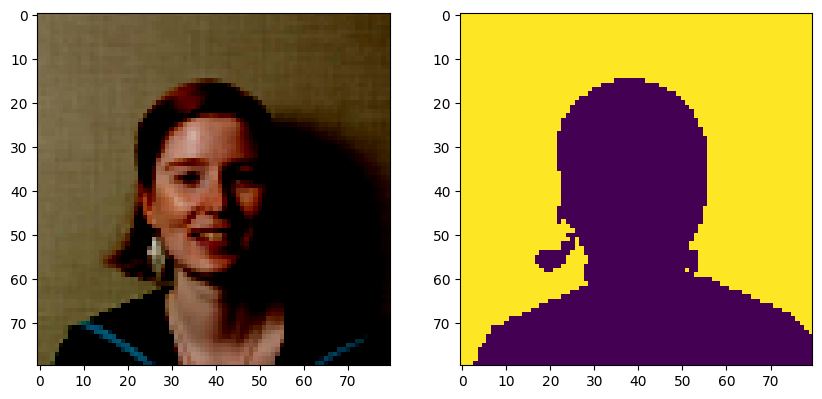

In [3]:
num_examples = 1

# create figure
fig = plt.figure(figsize=(10,24))

for i in range(0, num_examples):
    image, mask = test_dataset.__getitem__(i)

    print("image/mask type:        ", type(image), type(mask))
    print("image/mask shape:       ", image.shape, mask.shape)
    print("image/mask datatype:    ", image.dtype, mask.dtype)
    print("image min and max value:", image.min(), image.max())
    print("mask min and max value: " , mask.min(), mask.max())
 
    plt.subplot(num_examples,2,2*i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.subplot(num_examples,2,2*i+2)
    plt.imshow(mask)

plt.show()
